In [75]:
# Fish Position Tracking
# Script by Dhruv Zocchi PhD, Janelia Research Campus
# Updated by Jeremy Delahanty, Hopkins Neuroscience Program Rotation Student Ahrens Lab

# cv2 is the backbone of this processing pipeline
# In short, there's a workflow that performs background subtraction,
# thresholding, blob detection, and distance calculation all through
# opencv and numpy. Numpy is the numerical computation/optimized python distro
import cv2
import numpy as np

# Matplotlib is the classic plotting library
import matplotlib.pyplot as plt
# We use the Rectangle Patch object for annotating our distance plots
from matplotlib.patches import Rectangle

# Tkinter is a simple GUI library
from tkinter import Tk
from tkinter.filedialog import askdirectory

# Pathlib makes path manipulation a little nicer
from pathlib import Path

# tqdm gives you pretty progress bars
from tqdm.notebook import tqdm

# We use time for pausing thread execution, logging, and progress bars
import time

# This workflow relies heavily upon multithreading so work for processing
# and writing data. It doesn't have to, but it was fun to learn about
# Queues are how threads can "put" data in a spot that's ready to be
# taken up by another thread!
import threading
import queue

# Multiprocessing allows you to have multiple, easily accessed, independent
# non-blocking python processes to enable parallelism
from multiprocessing import Process, Queue

# h5py allows you to write to HDF5 files which are nice to use for organising
# multidimensional datasets with built in metadata/attributes
import h5py

# Currently, ROIs for a given set of experiments are stored as a config file
# stored as json
import json

# These are for debugging weird thread issues, not really in use now...
import warnings
import psutil
import traceback
import logging
import sys

# Visualization Functions During Processing

In [3]:
def get_average_brightness(image, position, text_size):
    """
    Calculate the average brightness of a region in the image.
    This can be used when trying to determine whether you should
    overlay black or white text over the image for writing out videos

    Parameters:
    - image: The image to calculate brightness on.
    - position: A tuple (x, y) specifying the position of the top-left corner of the region.
    - text_size: A tuple (width, height) specifying the size of the region.

    Returns:
    - The average brightness of the region.
    """
    x, y = position
    width, height = text_size
    region = image[y:y+height, x:x+width]
    return np.mean(region)

def add_text_to_image(image, text, position):
    """
    Add text to an image at the specified position, adjusting the color based on the background brightness.
    Used for overlaying black/white text over the image when writing out videos

    Parameters:
    - image: The image to add text to.
    - text: The text string to add.
    - position: A tuple (x, y) specifying the position of the text.

    Returns:
    - The image with the text added.
    """
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    thickness = 1
    text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
    avg_brightness = get_average_brightness(image, position, text_size)

    # Choose text color based on brightness
    if avg_brightness > 127:
        color = (0, 0, 0)  # Black color text
    else:
        color = (255, 255, 255)  # White color text

    cv2.putText(image, text, position, font, font_scale, color, thickness, cv2.LINE_AA)
    return image

def combine_images(images, cols, rows):
    """
    Use for creating one big "frame" composed of each processing step during
    fish detection
    """
    h, w = images[0].shape[:2]
    combined_image = np.zeros((h * rows, w * cols, 3), dtype=np.uint8)

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            if index < len(images):
                combined_image[i*h:(i+1)*h, j*w:(j+1)*w, :] = images[index]

    return combined_image

# Heatmap Functions from Dhruv and Plotting

In [189]:
def getHeatMapCts(posArr,binRangeX,binRangeY):
    xPos=posArr[:, 1]
    yPos=posArr[:, 0]
#count how many times position was within bin defined by binXIdx, binYIdx
    cts=posArr[(xPos>=binRangeX[0]) & (xPos<binRangeX[1]) & (yPos>=binRangeY[0]) & (yPos<binRangeY[1])].shape[0]
    return cts

#sweep along rows, starting from top row, count how many positions are in each bin
#heatMap is for figure, so has dim of original frame, heatMapData contains the counts
#in each heatmap bin, is used for the occupancy calc
def constructHeatMap(posArr,dim,numBinsX,numBinsY,numTimePts):
    # define bins, populate heatmap
    binsX = np.linspace(0, dim[0], numBinsX + 1)
    binsY = np.linspace(0, dim[1], numBinsY + 1)

    heatMap = np.zeros(dim)
    #heatMap = np.zeros([ int(roi[2]) , int(roi[3]) ])
    heatMapData = np.zeros([numBinsX, numBinsY])
    ctHist = []
    for i in range(0, numBinsX):
        for j in range(0, numBinsY):
            binRangeX = binsX[i:i+2]
            binRangeY = binsY[j:j+2]
            cts = getHeatMapCts(posArr, binRangeX, binRangeY)
            idxX = binRangeX.astype('int')
            idxY = binRangeY.astype('int')
            heatMap[idxX[0]:idxX[1], idxY[0]:idxY[1]] = cts
            heatMapData[i,j] = cts

    # normalize heatMap to show fraction time spent in each bin, apply blurring filter
    heatMap = heatMap / numTimePts
    heatMapData = heatMapData / numTimePts
    return heatMap, heatMapData, ctHist

def calculate_etoh_concentration():
    annotations = []
    # all measures in mL
    initial_chamber_volume = 250
    # approximate weight of 2% solution released per
    # solenoid opening
    # volume in mL * conversion factor * density
    mass_released_per_opening = 70
    # volume released per opening is approx 0.07mL
    volume_released_per_opening = 0.07
    # percentage of ethanol within a given volume
    volume_etoh_per_opening = 0.07 * 0.02
    # density at about room temp
    etoh_density = 0.789
    #mass etoh total is just volume
    ethanol_mass_per_opening = volume_etoh_per_opening * etoh_density
    total_ethanol_mass = 0
    current_volume = initial_chamber_volume
    counter = 0
    for i in range(1,100):
        counter += 1
        total_ethanol_mass += ethanol_mass_per_opening * counter
        current_volume += volume_released_per_opening
        annotations.append(round((total_ethanol_mass/current_volume)*100, 6))
        
    return annotations

# Logging, Debugging, Exceptions

In [ ]:
def log_frame_info(logger, video, frame_number):
    position = video.get(cv2.CAP_PROP_POS_MSEC)
    timestamp = video.get(cv2.CAP_PROP_POS_FRAMES) / video.get(cv2.CAP_PROP_FPS)
    logger.info(f"Frame {frame_number}:")
    logger.info(f"  Position: {position:.2f} ms")
    logger.info(f"  Timestamp: {timestamp:.2f} s")
    logger.info(f"  Is keyframe: {video.get(cv2.CAP_PROP_POS_FRAMES) == frame_number}")

def log_video_info(logger, video):
    fourcc = int(video.get(cv2.CAP_PROP_FOURCC))
    codec = "".join([chr((fourcc >> 8 * i) & 0xFF) for i in range(4)])
    logger.info(f"Video codec: {codec}")
    logger.info(f"FPS: {video.get(cv2.CAP_PROP_FPS)}")
    logger.info(f"Frame count: {int(video.get(cv2.CAP_PROP_FRAME_COUNT))}")
    logger.info(f"Format: {video.get(cv2.CAP_PROP_FORMAT)}")

def analyze_frame_difference(logger, prev_frame, curr_frame):
    if prev_frame is None or curr_frame is None:
        return
    diff = cv2.absdiff(prev_frame, curr_frame)
    non_zero = np.count_nonzero(diff)
    total = diff.size
    diff_ratio = non_zero / total
    logger.info(f"Frame difference ratio: {diff_ratio:.4f}")

def log_keyframe_info(logger, video, frame_number):
    logger.info(f"Frame {frame_number} is keyframe: {is_keyframe(video, frame_number)}")

def log_frame_read_time(logger, frame_number, read_time):
    logger.info(f"Frame {frame_number} read time: {read_time:.6f} seconds")

def log_retry_info(logger, retry, max_retries, frame_count, ret, frame):
    logger.info(f"Retry {retry + 1}/{max_retries} for frame {frame_count}")
    logger.info(f"  Return value: {ret}")
    logger.info(f"  Frame shape: {frame.shape if frame is not None else 'None'}")

def setup_logger(name, log_file, level=logging.INFO):
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    
    handler = logging.FileHandler(log_file)
    handler.setFormatter(formatter)

    logger = logging.getLogger(name)
    logger.setLevel(level)
    logger.addHandler(handler)

    return logger

def get_process_logger(video_path, process_name):
    log_dir = Path(video_path).parent / "logs"
    log_dir.mkdir(exist_ok=True)
    log_file = log_dir / f"{Path(video_path).stem}_{process_name}.log"
    return setup_logger(f"{Path(video_path).stem}_{process_name}", log_file)


def log_memory_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    print(f"Memory usage: {memory_info.rss / (1024 * 1024):.2f} MB")

class ConfigError(Exception):
    """
    Exception for when there's an error with Config Files.
    """
    def __init__(self, *args):
        if args:
            self.message = args[0]
        else:
            self.message = None

    def __str__(self):
        if self.message:
            return "TemplateError: " + "{0}".format(self.message)
        else:
            return "TEMPLATE ERROR"

class VideoReadError(Exception):
    """Custom exception for video read errors."""
    pass

class VideoProcessingWarning(Warning):
    """Custom warning for video processing issues."""
    pass

# Main Functions for Parallelized Video Processing

In [ ]:
def preprocess_video(video, data_directory, roi=None):
    # pass video object
    # Set the video position to the first frame
    # We shouldn't enter this function unless the video can be opened.
    # Get the first image as the ROI selection after you're sure you've
    # gotten the frame successfully read
    video.set(cv2.CAP_PROP_POS_FRAMES, 0)
    
    # cap.read() tells you if the frame retrieval was successful (boolean)
    # through ret, frame is the numpy array array that opencv returns
    ret, frame = video.read()

    # If the frame is returned (if ret is true)
    if ret:
        # Get the image and convert it to a numpy array shaped as an image in grayscale
        first_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    roi = check_metadata(data_directory)

    # Get the ROI used for cropping successive images
    # Returns the ROI and the cropped frame iff there isn't
    # one already available
    if roi is None:
        print("No ROI File Found, Generating ROI")
        roi = get_roi(first_image)
        metadata = {"roi":
                        {"x": roi[0],
                         "y": roi[1],
                         "w": roi[2],
                         "h": roi[3]
                        }
                   }

        metadata_path = [data_directory / directory / "metadata.json" for directory in data_directory.glob("*")]
        with open(metadata_path[0], 'w') as outFile:
            json.dump(
                metadata,
                outFile,
                indent=4
            )
                
    else:
        print("ROI Loaded from Metadata File")
        roi = roi

    # crop the frame with the ROI selected
    cropped = frame[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]

    # Now we need to crop the frame, display it, and let the user
    # select multiple points for each port in the chamber
    points = get_points(first_image)
    
    # Now we want some other frame as background, you can technically pick any random
    # frame but it'd be cool in the future to have a static background image gathered for each
    # recording
    # Get random video frame, hoping that the fish has moved by now to a new position
    video.set(cv2.CAP_PROP_POS_FRAMES, 200)

    ret, frame = video.read()

    if ret:
        # Get the image and convert it to a numpy array shaped as an image in grayscale
        background = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Crop the background that will be used for all computations on this video
    background = background[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]

    return points, background, roi

def get_points(frame):
    points = []  # Local to select_points
    copy = frame.copy()  # Local to select_points
    
    def click_event(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            points.append((x, y))  # Accessing and modifying points from the outer function
            cv2.circle(copy, (x, y), 5, (0, 255, 0), -1)  # Modifying copy from the outer function
            cv2.imshow("Port Selection", copy)
            if len(points) >= 4:
                cv2.setMouseCallback("Port Selection", lambda *args : None)  # Disabling further callbacks when 4 points are selected

    # Setting up the callback
    cv2.imshow("Port Selection", copy)
    cv2.setMouseCallback("Port Selection", click_event)

    while len(points) < 4:
        cv2.waitKey(1)

    cv2.destroyAllWindows()

    # The user must be told to always select in the following order:
    # 1. EtOH 2. H2O 3. Inlet 4. Outlet
    # Points is returned as a list of tuples with x/y coords
    return points

def get_roi(frame):
    roi = cv2.selectROI("Select ROI, Hit Esc to Exit", frame)
    
    while True:
        if cv2.waitKey(1) & 0xFF == 27:  # Press 'ESC' to exit
            break
    cv2.destroyAllWindows()

    return roi
    

def get_videos(data_directory):
    # data_directory must be a pathlib Path object
    video_paths = sorted([path for path in data_directory.glob("*/*/*.avi")])
    return video_paths

def check_h5(video_path):
    # check if the path has an h5 file already. If it does we probably don't mean
    # to reanalyze it (unless we do at some point?)
    files = [file for file in video_path.parent.glob("*.h5")]

def check_metadata(data_directory):
    # see if a json file encoding metadata for the session is available
    # For now, if it does, give the roi. This should be on a session by
    # session basis and named differently.
    # This, for now, is just to check if a given group of fish has
    # a defined ROI or not
    metadata = [file for file in data_directory.glob("*/*.json")]
    try:
        with open(metadata[0], 'r') as inFile:
    
            contents = inFile.read()
    
            # Use json.loads to gather metadata and save them in an
            # ordered dictionary
            config = json.loads(
                contents
            )
    except IndexError:
        roi = None
        return roi

    roi = (config["roi"]["x"], config["roi"]["y"], config["roi"]["w"], config["roi"]["h"])

    return roi

def monitor_queues(data_queue, progress_queue, stop_event, interval=60.0):
    while not stop_event.is_set():
        data_queue_size = data_queue.qsize()
        progress_queue_size = progress_queue.qsize()
        print(f"[Queue Monitor] Data Queue Size: {data_queue_size}, Progress Queue Size: {progress_queue_size}")
        print(f"Data Queue Full: {data_queue.full()}, Progress Queue Full: {progress_queue.full()}")
        time.sleep(interval)

def get_total_frames(video_path):
    cap = cv2.VideoCapture(str(video_path))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return total_frames

def data_producer(video, data_queue, stop_event, roi, background, points, previous_location, total_frames, progress_queue, video_name):
    frame_count = 0
    max_retries = 10
    retry_count = 0
    try:
        while not stop_event.is_set() and video.isOpened() and frame_count < total_frames:
            ret, frame = video.read()
            if not ret:
                while retry_count < max_retries:
                    print(f"Retrying frame {frame_count}, attempt {retry_count + 1}/{max_retries}")
                    video.set(cv2.CAP_PROP_POS_FRAMES, frame_count)
                    ret, frame = video.read()
                    retry_count += 1
                    if ret:
                        break

            frame_count += 1   
            frame = cv2.cvtColor(np.array(frame), cv2.COLOR_BGR2GRAY)
            cropped = frame[roi[1]:roi[1] + roi[3], roi[0]:roi[0] + roi[2]]
    
            if not isinstance(background, np.ndarray):
                raise ValueError("Background frame (background) is not a numpy array.")
            if cropped.shape != background.shape:
                raise ValueError(f"Cropped frame shape {cropped.shape} does not match background frame shape {background.shape}.")
    
            subtracted = cv2.subtract(background, cropped)
            blurred = cv2.GaussianBlur(subtracted, (3, 3), 0)
            _, thresholded = cv2.threshold(blurred, 20, 255, 0)
            inverted = cv2.bitwise_not(thresholded)
            median = cv2.medianBlur(thresholded, 7)
            contours, _ = cv2.findContours(median, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            filtered_contours_and_areas = [(contour, cv2.contourArea(contour)) for contour in contours if cv2.contourArea(contour) > 20]
            if filtered_contours_and_areas:
                filtered_contours = [contour for contour, area in [max(filtered_contours_and_areas, key=lambda x: x[1])]]
                contour = filtered_contours[0]
                moments = cv2.moments(contour)
                cX = round(int(moments["m10"] / moments["m00"]), 2)
                cY = round(int(moments["m01"] / moments["m00"]), 2)
                previous_location[0], previous_location[1] = cX, cY
            else:
                if previous_location[0] is not None and previous_location[1] is not None:
                    cX = previous_location[0]
                    cY = previous_location[1]
                else:
                    cX = np.nan
                    cY = np.nan
    
            dist_etoh = np.linalg.norm(np.array(points[0]) - np.array([cX, cY]))
            dist_h2o = np.linalg.norm(np.array(points[1]) - np.array([cX, cY]))
    
            data_queue.put((cX, cY, dist_etoh, dist_h2o))
            progress_queue.put(1)
    
    except VideoReadError as e:
        print(f"Video read error: {str(e)}")
        print(f"Last successfully read frame: {frame_count}")
        print(f"Video info: total_frames={total_frames}, isOpened={video.isOpened()}")
    except Exception as e:
        print(f"Unexpected error in producer: {str(e)}")
        print(traceback.format_exc())
    finally:
        stop_event.set()

def data_consumer(data_queue, stop_event, file_path, roi, points):
    with h5py.File(file_path, 'w') as h5f:
        dset_center = h5f.create_dataset('center', (0, 2), maxshape=(None, 2), dtype='f')
        dset_dist_etoh = h5f.create_dataset('dist_etoh', (0,), maxshape=(None,), dtype='f')
        dset_dist_h2o = h5f.create_dataset('dist_h2o', (0,), maxshape=(None,), dtype='f')

        h5f.attrs['roi'] = roi
        h5f.attrs['points'] = np.array(points).flatten()

        while not stop_event.is_set() or not data_queue.empty():
            try:
                cX, cY, dist_etoh, dist_h2o = data_queue.get(timeout=1)

                dset_center.resize(dset_center.shape[0] + 1, axis=0)
                dset_dist_etoh.resize(dset_dist_etoh.shape[0] + 1, axis=0)
                dset_dist_h2o.resize(dset_dist_h2o.shape[0] + 1, axis=0)

                dset_center[-1] = [cX, cY]
                dset_dist_etoh[-1] = dist_etoh
                dset_dist_h2o[-1] = dist_h2o

                data_queue.task_done()
            except queue.Empty:
                continue

def process_video(path, data_directory, progress_queue, position, video_name):
    print(f"Processing: {path.stem}")

    video = cv2.VideoCapture(str(path))
    if not video.isOpened():
        raise ValueError("Failed to open the video file.")
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    vid_name = Path(path).stem
    
    points, background, roi = preprocess_video(video, data_directory)  # Assuming preprocess_video is defined elsewhere

    h5_filepath = path.parent / f"{vid_name}_output.h5"
    data_queue = queue.Queue(maxsize=100)
    stop_event = threading.Event()
    previous_location = [None, None]
    
    producer_thread = threading.Thread(target=data_producer, args=(video, data_queue, stop_event, roi, background, points, previous_location, total_frames, progress_queue, vid_name))
    consumer_thread = threading.Thread(target=data_consumer, args=(data_queue, stop_event, h5_filepath, roi, points))

    producer_thread.start()
    consumer_thread.start()

    try:
        with tqdm(total=total_frames, desc=f'Process {video_name}', position=position, leave=True) as progress_bar:
            while producer_thread.is_alive() or not data_queue.empty():
                while not progress_queue.empty():
                    progress_bar.update(progress_queue.get())
                time.sleep(0.1)  # Small sleep to prevent excessive CPU usage

            # Ensure the progress bar completes
            progress_bar.update(progress_bar.total - progress_bar.n)

    except KeyboardInterrupt:
        print("Stopping...")
        stop_event.set()
    finally:
        stop_event.set()
        producer_thread.join()
        consumer_thread.join()
        video.release()
        cv2.destroyAllWindows()
        print("Data processing completed.")

    video.release()

def process_worker(video, data_directory, position, video_name):
    progress_queue = Queue()
    process_video(video, data_directory, progress_queue, position, video_name)

def main():
    Tk().withdraw()
    data_directory = Path(askdirectory())
    video_paths = get_videos(data_directory)
    processes = []
    for i, video_path in enumerate(video_paths):
        video_name = video_path.stem
        process = Process(target=process_worker, args=(video_path, data_directory, i, video_name))
        process.start()
        processes.append(process)

    for process in processes:
        process.join()

In [76]:
if __name__ == "__main__":
    check = input("Are you sure?")
    if check == 'y':
        main()
    else:
        print("bye bye!")
        exit

Are you sure? n


bye bye!


SystemExit: 

/home/jmdelahanty/miniforge3/envs/sleap_analysis/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Get Data from Processing

In [184]:
Tk().withdraw()
data_directory = Path(askdirectory())
h5_files = sorted([file for file in data_directory.glob("*/*/*.h5")])

# Plot Data from Processing

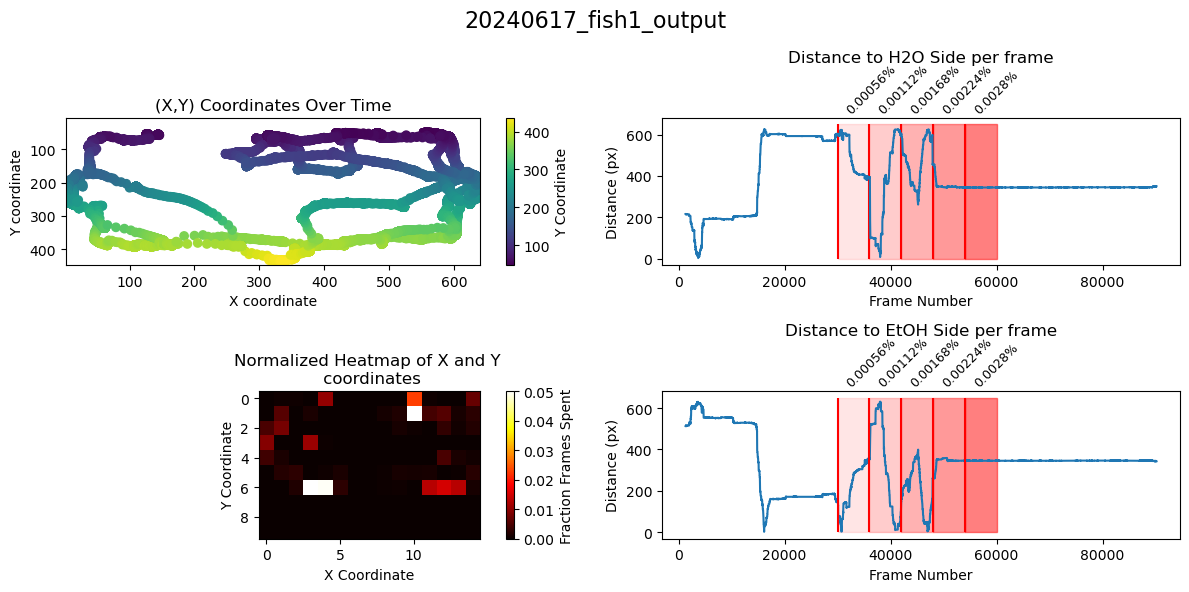

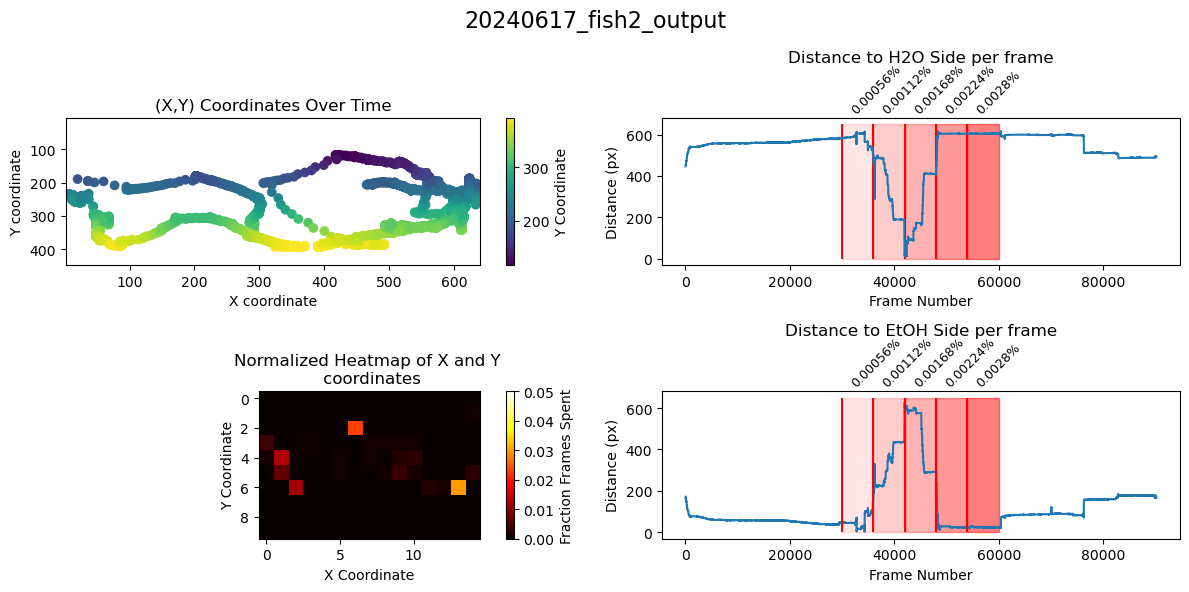

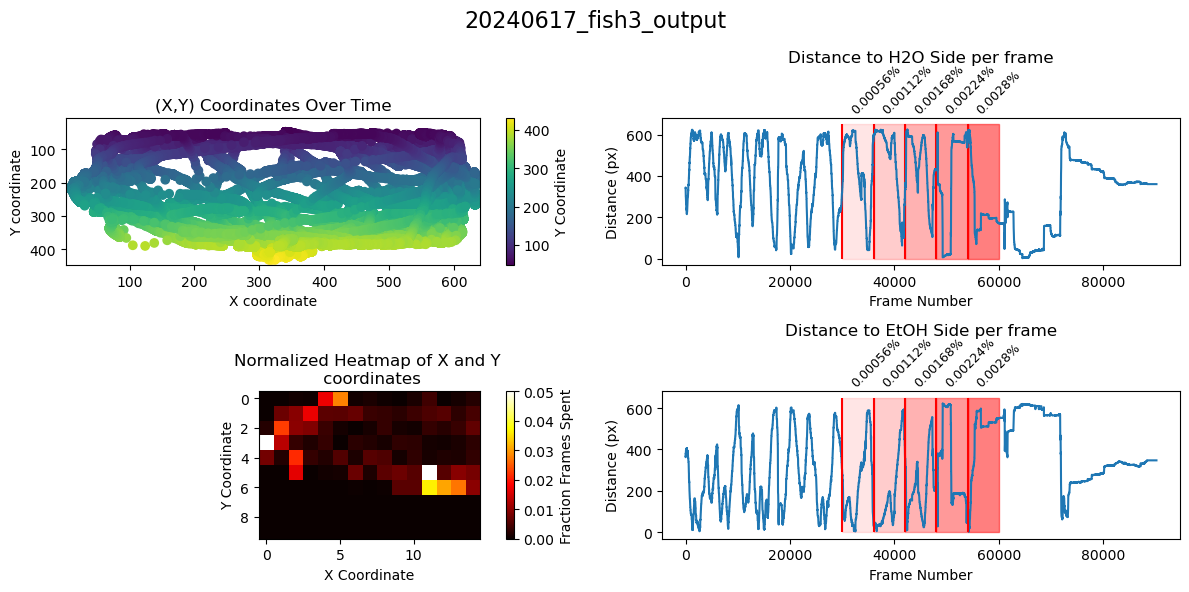

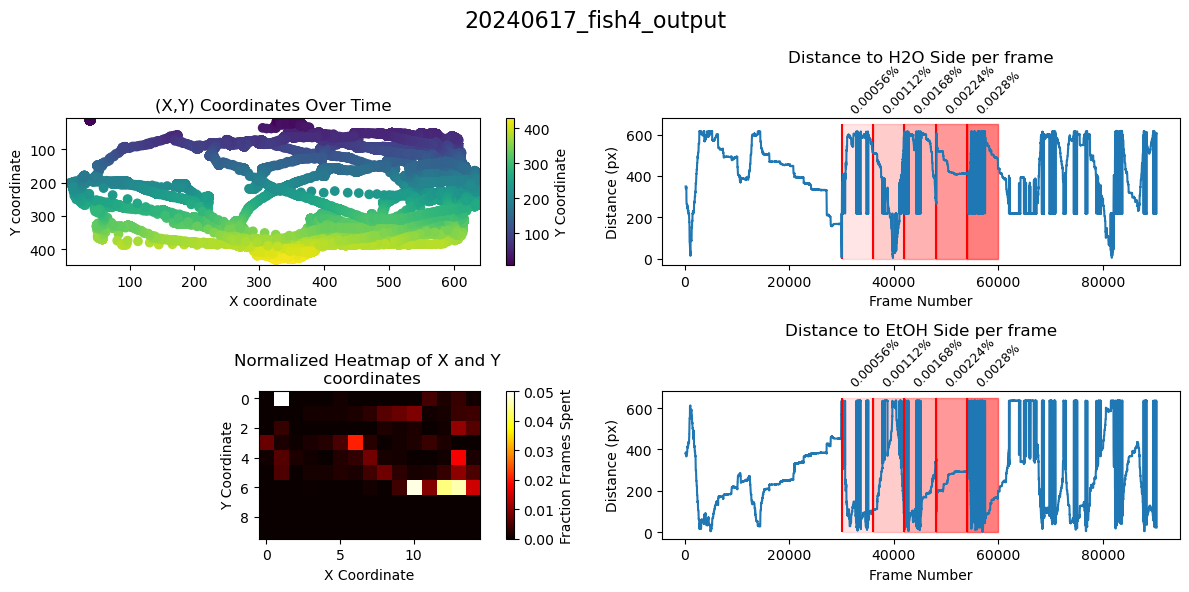

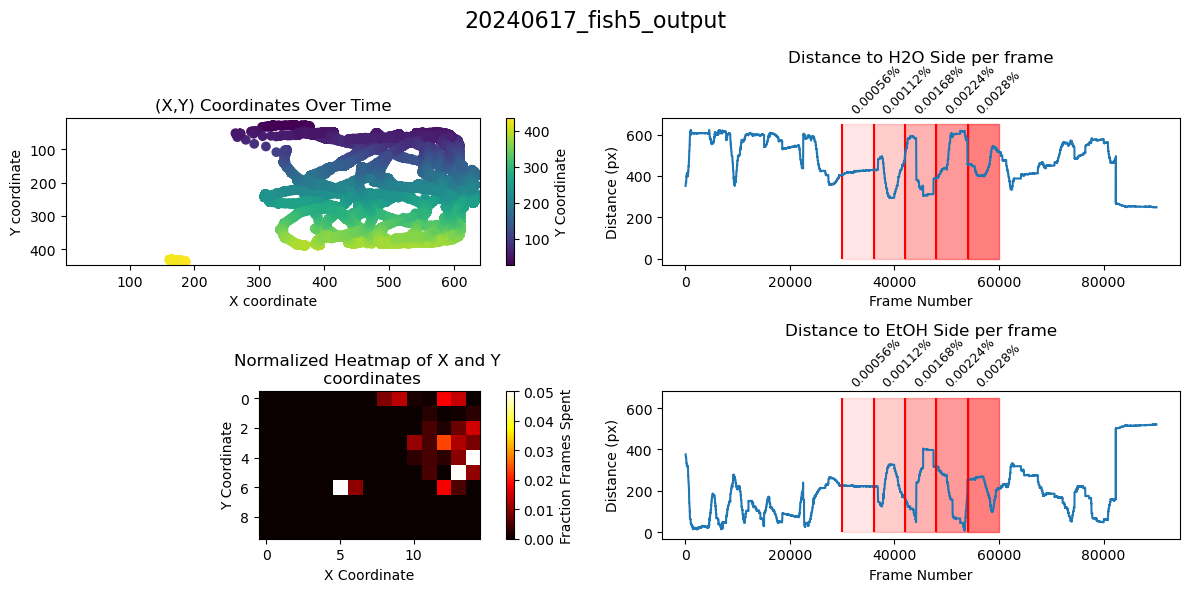

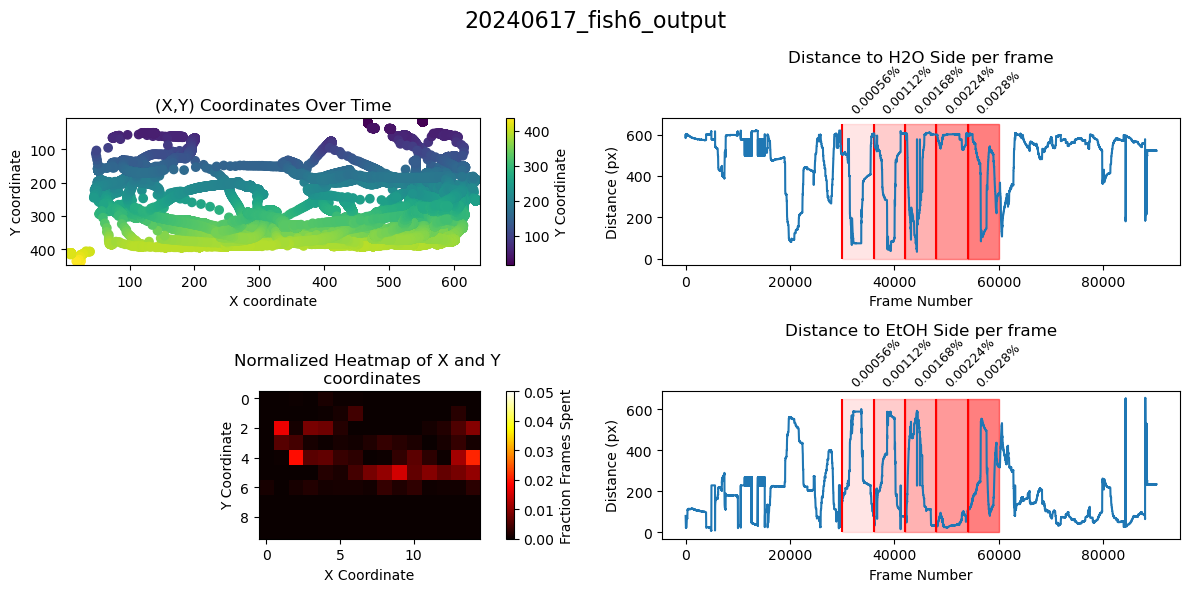

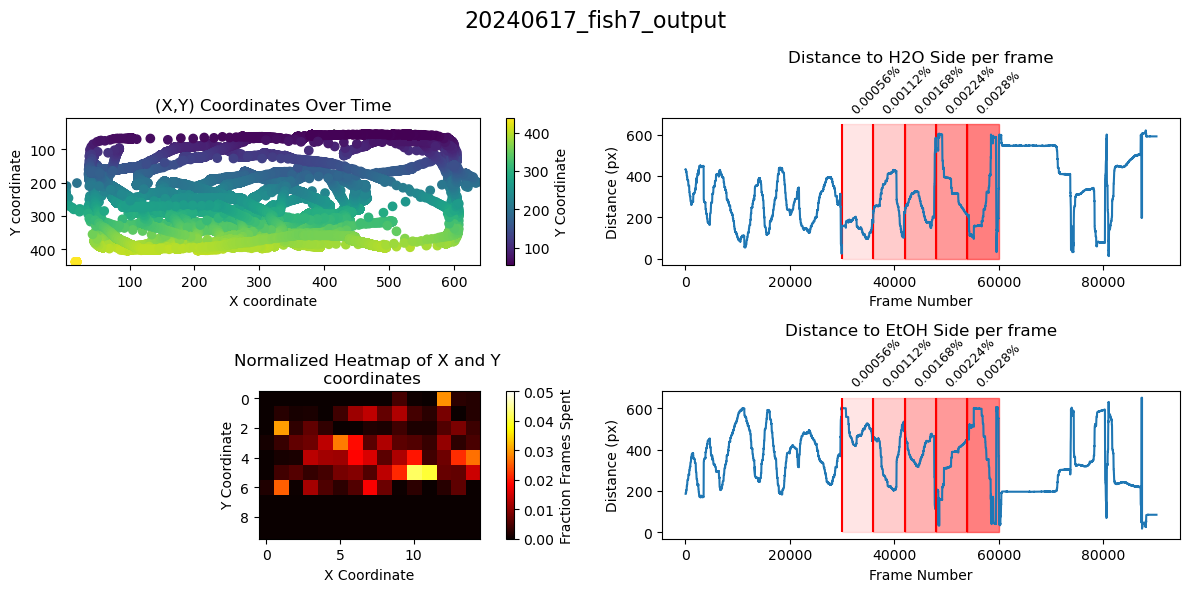

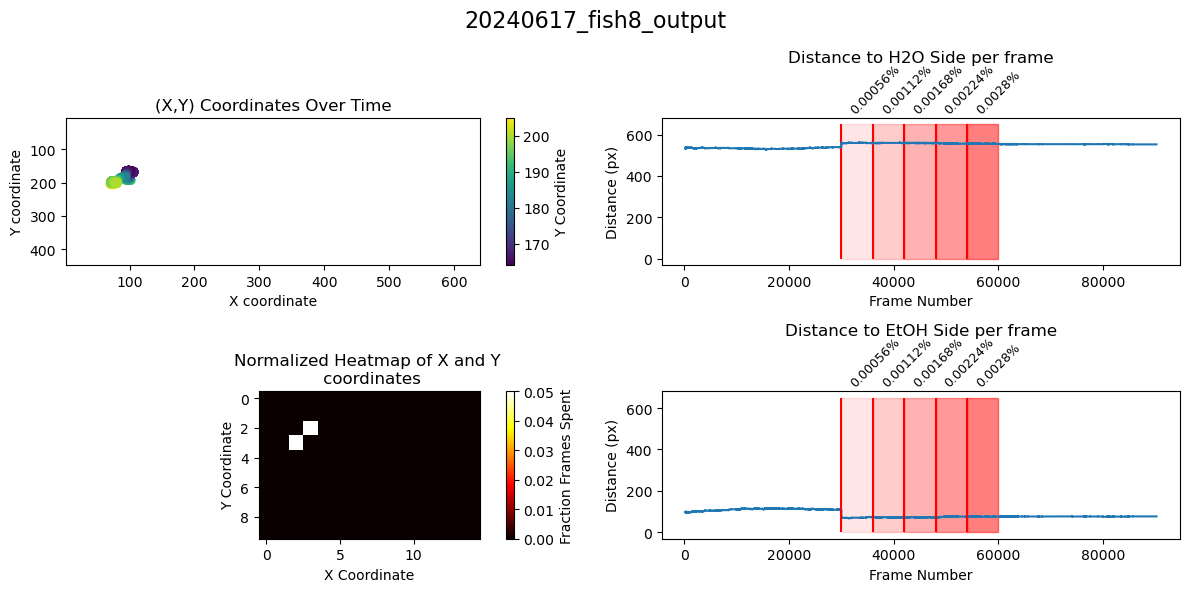

In [188]:
for file in h5_files:
    with h5py.File(file, 'r') as inFile:
        # Access the "center" dataset
        center_data = inFile['center']
        h2o_data = inFile['dist_h2o']
        etoh_data = inFile['dist_etoh']
        roi = inFile.attrs['roi']
        c = center_data[:,:]
        c_filtered = center_data[~np.isnan(center_data).any(axis=1)]
        x = center_data[:, 0]
        y = center_data[:, 1]
        mask = ~np.isnan(y)
        x_filtered = x[mask]
        y_filtered = y[mask]
        h2o = h2o_data[:]
        etoh = etoh_data[:]
        filename=file.stem
    
    rectangles = []
    rectangles2 = []
    annotations = []
    anchors = []
    stim_positions = []
    counter = 0
    for i in range(30000, 60000, 6000):
        counter += 1
        alpha = 0.10
        rectangles.append(
            Rectangle((i, 0), 6000, 650, angle=0.0, color='red', alpha=alpha*counter)
        )
        rectangles2.append(
            Rectangle((i, 0), 6000, 650, angle=0.0, color='red', alpha=alpha*counter)
        )
        rectangle_anchor = (i, 0)
        etoh_conc = str(round((((0.0014*counter)/250)*100), 8))+"%"
        anchors.append(rectangle_anchor)
        annotations.append(etoh_conc)
        stim_positions.append(i)
    
    fig, axs = plt.subplots(2,2, figsize=(12,6))
    colors = y_filtered
    sc = axs[0, 0].scatter(x_filtered, y_filtered, c=colors, cmap='viridis')
    cb_pos = fig.colorbar(sc, ax=axs[0, 0])
    cb_pos.set_label('Y Coordinate')
    axs[0, 0].set_xlim(roi[0], roi[0] + roi[2])
    axs[0, 0].set_ylim(roi[1] + roi[3], roi[1])  # Inverting y axis
    axs[0, 0].set_xlabel('X coordinate')
    axs[0, 0].set_ylabel('Y coordinate')
    axs[0, 0].set_title('(X,Y) Coordinates Over Time')
    
    numBinsX = 10
    aspectRatio = roi[2]/roi[3]
    numBinsY=int(np.ceil(numBinsX*aspectRatio))
    
    heatMap, heatMapData, cHist = constructHeatMap(c_filtered, (roi[2],roi[3]), numBinsX, numBinsY, x_filtered.shape[0])
    # Heatmap in the second subplot
    # heatmap, xedges, yedges = np.histogram2d(
    #     x_filtered,
    #     y_filtered,
    #     bins=[numBinsX, numBinsY],
    #     range=[[0, roi[3]], [0, roi[2]]]
    # )
    
    # Overlay transformed x_filtered, y_filtered data points on the heatmap
    # heatmap_normalized = heatmap / x_filtered.shape[0]
    # extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = axs[1, 0].imshow(heatMapData, cmap='hot', vmin=0, vmax=0.05)
    cb = fig.colorbar(im, ax=axs[1, 0])  
    cb.set_label('Fraction Frames Spent')
    axs[1, 0].set_aspect('equal', adjustable='box')
    axs[1, 0].set_xlabel('X Coordinate')
    axs[1, 0].set_ylabel('Y Coordinate')
    axs[1, 0].set_title('Normalized Heatmap of X and Y \n coordinates')
    axs[1,0].set_aspect('equal', adjustable='box')
    axs[0,1].set_title("Distance to H2O Side per frame", pad=40)
    axs[0,1].vlines(stim_positions, 0, 650, color='red')
    for rectangle in rectangles:
        axs[0,1].add_patch(rectangle)
    for annotation, anchor in zip(annotations, anchors):
        axs[0,1].annotate(annotation,
                          xy=anchor,
                          xytext=(5, 105),
                          textcoords='offset points',
                          fontsize=9,
                          color='black',
                          rotation=45)
    axs[0,1].set_xlabel("Frame Number")
    axs[0,1].set_ylabel("Distance (px)")
    axs[0,1].plot(h2o)
    for rectangle in rectangles2:
        axs[1,1].add_patch(rectangle)
    for annotation, anchor in zip(annotations, anchors):
        axs[1,1].annotate(annotation,
                          xy=anchor,
                          xytext=(5, 105),
                          textcoords='offset points',
                          fontsize=9,
                          color='black',
                          rotation=45)
    axs[1,1].set_xlabel("Frame Number")
    axs[1,1].set_ylabel("Distance (px)")
    axs[1,1].plot(etoh)
    axs[1,1].set_title("Distance to EtOH Side per frame", pad=40)
    axs[1,1].vlines(stim_positions, 0, 650, color='red')
    fig.suptitle(f'{filename}', fontsize=16)
    fig.tight_layout()
    plt.savefig(f'{filename}.png')
    plt.show()
    plt.close()

# Plot Mean of All Data

Processing file: /home/jmdelahanty/ahrens_data/free_swimming_1_etoh_port/fish1/20240617_fish1_output.h5
Processing file: /home/jmdelahanty/ahrens_data/free_swimming_1_etoh_port/fish2/20240617_fish2_output.h5
Processing file: /home/jmdelahanty/ahrens_data/free_swimming_1_etoh_port/fish3/20240617_fish3_output.h5
Processing file: /home/jmdelahanty/ahrens_data/free_swimming_1_etoh_port/fish4/20240617_fish4_output.h5
Processing file: /home/jmdelahanty/ahrens_data/free_swimming_1_etoh_port/fish5/20240617_fish5_output.h5
Processing file: /home/jmdelahanty/ahrens_data/free_swimming_1_etoh_port/fish6/20240617_fish6_output.h5
Processing file: /home/jmdelahanty/ahrens_data/free_swimming_1_etoh_port/fish7/20240617_fish7_output.h5
Processing file: /home/jmdelahanty/ahrens_data/free_swimming_1_etoh_port/fish8/20240617_fish8_output.h5


/tmp/ipykernel_1053132/2722050587.py:18: RuntimeWarning: Mean of empty slice
  stacked_all_h2o_mean = np.nanmean(stacked_all_h2o, axis=0)
/tmp/ipykernel_1053132/2722050587.py:19: RuntimeWarning: Mean of empty slice
  stacked_all_etoh_mean = np.nanmean(stacked_all_h2o, axis=0)


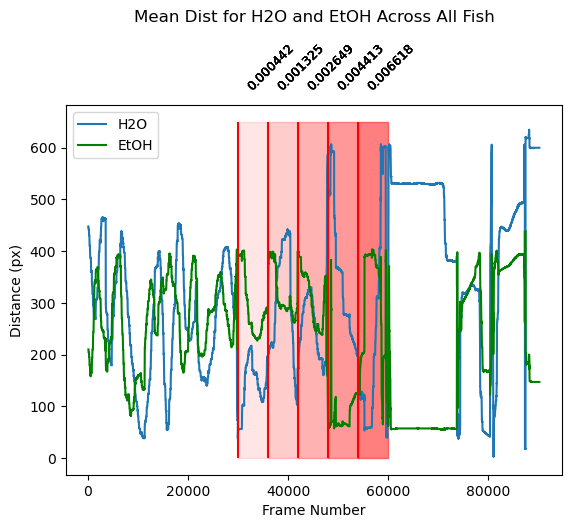

In [185]:
all_h2o = []
all_etoh = []

for i in h5_files:
    print(f"Processing file: {i}")
    with h5py.File(i, 'r') as file:
        h2o_data = file['dist_h2o']
        etoh_data = file['dist_etoh']
        h2o = np.array(h2o_data[0:90000])
        etoh = np.array(etoh_data[0:90000])
        all_h2o.append(h2o)
        all_etoh.append(etoh)


# Stack the data vertically
stacked_all_h2o = np.vstack(all_h2o)
stacked_all_etoh = np.vstack(all_etoh)
stacked_all_h2o_mean = np.nanmean(stacked_all_h2o, axis=0)
stacked_all_etoh_mean = np.nanmean(stacked_all_h2o, axis=0)

rectangles = []
achors = []
annotations = []
counter = 0
for i in range(30000, 60000, 6000):
    counter += 1
    alpha = 0.10
    rectangles.append(
        Rectangle((i, 0), 6000, 650, angle=0.0, color='red', alpha=alpha*counter)
    )
    rectangles2.append(
        Rectangle((i, 0), 6000, 650, angle=0.0, color='red', alpha=alpha*counter)
    )
    rectangle_anchor = (i, 0)
    annotations = calculate_etoh_concentration()
    anchors.append(rectangle_anchor)
fig, axis = plt.subplots()
axis.plot(x, label='H2O')
axis.plot(y, label='EtOH', color='green')
axis.vlines(stim_positions, 0, 650, color='red')
for rectangle in rectangles:
    axis.add_patch(rectangle)
    for annotation, anchor in zip(annotations, anchors):
        axis.annotate(annotation,
                          xy=anchor,
                          xytext=(5, 265),
                          textcoords='offset points',
                          fontsize=9,
                          color='black',
                          rotation=45)
axis.set_xlabel("Frame Number")
axis.set_ylabel("Distance (px)")
axis.set_title("Mean Dist for H2O and EtOH Across All Fish", pad=60)
axis.legend()
plt.show()
plt.close()

# Plot Mean of Just Good Fish

Processing file: /home/jmdelahanty/ahrens_data/free_swimming_1_etoh_port/fish1/20240617_fish1_output.h5
Processing file: /home/jmdelahanty/ahrens_data/free_swimming_1_etoh_port/fish3/20240617_fish3_output.h5
Processing file: /home/jmdelahanty/ahrens_data/free_swimming_1_etoh_port/fish5/20240617_fish5_output.h5
Processing file: /home/jmdelahanty/ahrens_data/free_swimming_1_etoh_port/fish6/20240617_fish6_output.h5
Processing file: /home/jmdelahanty/ahrens_data/free_swimming_1_etoh_port/fish7/20240617_fish7_output.h5


/tmp/ipykernel_1053132/184047011.py:17: RuntimeWarning: Mean of empty slice
  filtered_h2o = np.nanmean(stacked_h2o, axis=0)
/tmp/ipykernel_1053132/184047011.py:18: RuntimeWarning: Mean of empty slice
  filtered_etoh = np.nanmean(stacked_etoh, axis=0)


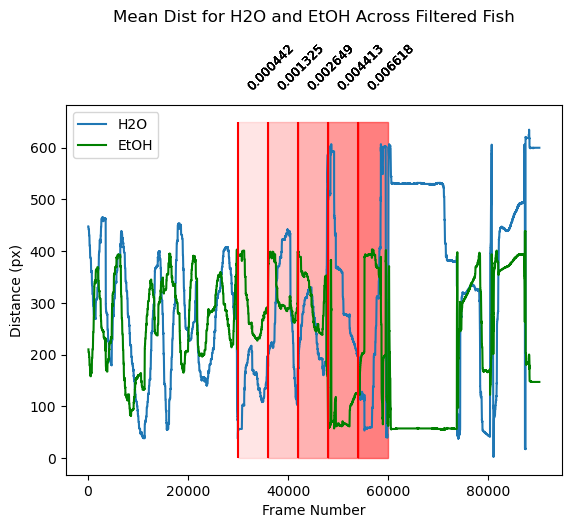

In [186]:
good_fish = ["fish1", "fish3", "fish5", "fish6", "fish7"]
for i in h5_files:
    fish_id = i.parts[-2]  # Extract the fish identifier from the path
    if fish_id in good_fish:
        print(f"Processing file: {i}")
        with h5py.File(i, 'r') as file:
            h2o_data = file['dist_h2o']
            etoh_data = file['dist_etoh']
            h2o = np.array(h2o_data[0:90000])
            etoh = np.array(etoh_data[0:90000])
            full_h2o.append(h2o)
            full_etoh.append(etoh)

# Stack the data vertically
stacked_h2o = np.vstack(full_h2o)
stacked_etoh = np.vstack(full_etoh)
filtered_h2o = np.nanmean(stacked_h2o, axis=0)
filtered_etoh = np.nanmean(stacked_etoh, axis=0)
rectangles = []
achors = []
annotations = []
counter = 0
for i in range(30000, 60000, 6000):
    counter += 1
    alpha = 0.10
    rectangles.append(
        Rectangle((i, 0), 6000, 650, angle=0.0, color='red', alpha=alpha*counter)
    )
    rectangles2.append(
        Rectangle((i, 0), 6000, 650, angle=0.0, color='red', alpha=alpha*counter)
    )
    rectangle_anchor = (i, 0)
    annotations = calculate_etoh_concentration()
    anchors.append(rectangle_anchor)
fig, axis = plt.subplots()
axis.plot(x, label='H2O')
axis.plot(y, label='EtOH', color='green')
axis.vlines(stim_positions, 0, 650, color='red')
for rectangle in rectangles:
    axis.add_patch(rectangle)
    for annotation, anchor in zip(annotations, anchors):
        axis.annotate(annotation,
                          xy=anchor,
                          xytext=(5, 265),
                          textcoords='offset points',
                          fontsize=9,
                          color='black',
                          rotation=45)
axis.set_xlabel("Frame Number")
axis.set_ylabel("Distance (px)")
axis.set_title("Mean Dist for H2O and EtOH Across Filtered Fish", pad=60)
axis.legend()
plt.show()
plt.close()

In [190]:
tester = calculate_etoh_concentration()

In [194]:
len(tester) - 5 + 1

95

# BELOW IS SCRAPS

___

# ################################################<3#######################

In [10]:
a, b, c = constructHeatMap(c_filtered, dim, numBinsX, numBinsY, c_filtered.shape[0])

In [9]:
aspectRatio = roi[2]/roi[3]
numBinsX = 10
numBinsY = int(np.ceil(numBinsX*aspectRatio))
dim=np.array([int(roi[3]),int(roi[2])])

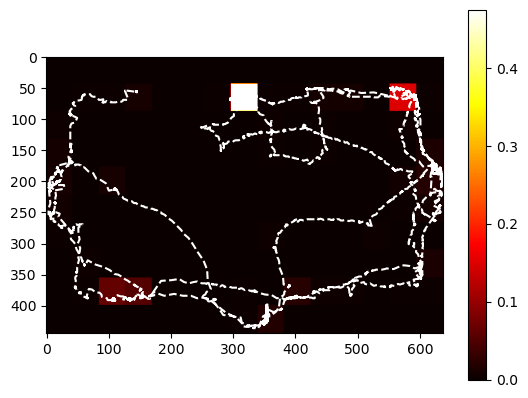

In [16]:
plt.imshow(a, cmap='hot')
plt.colorbar()
plt.plot(x_filtered, y_filtered, '--w')

In [32]:
def get_video_info(video_path):
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise VideoReadError(f"Failed to open the video file: {video_path}")
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = total_frames / fps if fps > 0 else 0
    
    print(f"Video info: {total_frames} frames, {fps} FPS, Duration: {duration:.2f} seconds")
    
    cap.release()
    return total_frames, fps, duration
data_directory = Path(askdirectory())
video_paths = get_videos(data_directory)
# Call this function before processing each video
total_frames, fps, duration = get_video_info(video_paths[0])

Video info: 1001 frames, 100.0 FPS, Duration: 10.01 seconds


In [6]:
def count_frames_manually(video_path):
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise VideoReadError(f"Failed to open the video file: {video_path}")
    
    frame_count = 0
    while True:
        ret, _ = cap.read()
        if not ret:
            break
        frame_count += 1
    
    cap.release()
    return frame_count


# In your data_producer function:
# ret, frame = video.read()
# if not ret or not check_frame_integrity(frame):
#     print(f"Invalid frame at count {frame_count}")
#     # Handle the error (retry, skip, or break)

# Compare this with the metadata
# manual_frame_count = count_frames_manually(video_paths[0])
# print(f"Manual frame count: {manual_frame_count}, Metadata frame count: {total_frames}")

In [ ]:
%%timeit -n 1
# Get background that we'll use to subtract from every frame
# although this should maybe be a static image gathered at the
# start of each day/imaging session?
posList = []
disth2o = []
distetoh = []
thresh = 20
area = [1, 100]
video = cv2.VideoCapture(filename)
previous_location = None
if not video.isOpened():
    print("Could not load video! Is the video broken or path correct?")
video.set(cv2.CAP_PROP_POS_FRAMES, 0)
# Get the width and height of the frames
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output video file
output_filename = 'combined_video_output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec
# out = cv2.VideoWriter(output_filename, fourcc, 100, (width * 3, height * 3))

while (video.isOpened()):
    # Capture frame-by-frame
    ret, frame = video.read()
    if not ret:
        cX = roi[0] + roi[2] // 2
        cY = roi[1] + roi[3] // 2
        dist_etoh = 0
        dist_h2o = 0
    else:
        frame = cv2.cvtColor(np.array(frame), cv2.COLOR_BGR2GRAY)
        cropped = frame[roi[1]:roi[1] + roi[3], roi[0]:roi[0] + roi[2]]
        subtracted = cv2.subtract(bkgrnd, cropped)
        blurred = cv2.GaussianBlur(subtracted, (3,3), 0)
        r, thresholded = cv2.threshold(blurred, 20, 255, 0)
        inverted = cv2.bitwise_not(thresholded)
        median = cv2.medianBlur(thresholded, 7)
        contours, hierarchy = cv2.findContours(
            median, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
        )
        filtered_contours_and_areas = [
        (contour, cv2.contourArea(contour))for contour in contours if cv2.contourArea(contour) > 20]
        if filtered_contours_and_areas:
            filtered_contours = [contour for contour, area in [max(filtered_contours_and_areas, key=lambda x: x[1])]]
            contour = filtered_contours[0]
            moments = cv2.moments(contour)
            cX = round(int(moments["m10"] / moments["m00"]), 2)
            cY = round(int(moments["m01"] / moments["m00"]), 2)
            previous_location_x, previous_location_y = cX, cY
        else:
            print("FISH NOT FOUND!")
            print("Interpolating...")
            if previous_location_x is not None and previous_location_y is not None:
                cX = previous_location_x
                cY = previous_location_y
            else:
                # Default to the center of the ROI if no previous location is known
                cX = roi[0] + roi[2] // 2
                cY = roi[1] + roi[3] // 2
    dist_etoh = np.linalg.norm(np.array(points[0]) - np.array([cX, cY]))
    dist_h2o = np.linalg.norm(np.array(points[1]) - np.array([cX, cY]))
    disth2o.append(dist_h2o)
    distetoh.append(dist_etoh)
    # img_rgb = cv2.cvtColor(reinvert, cv2.COLOR_GRAY2BGR)
    # cv2.drawContours(img_rgb, filtered_contours, -1, (0, 255, 0), thickness=cv2.FILLED)
    # img_rgb = cv2.circle(img_rgb, (cX,cY), radius=3, color=(255, 0, 0), thickness=-1)
    
    # # Add text to each sub-image
    # cropped_with_text = add_text_to_image(cv2.cvtColor(cropped, cv2.COLOR_GRAY2BGR), "Cropped", (10, 20))
    # subtracted_with_text = add_text_to_image(cv2.cvtColor(subtracted, cv2.COLOR_GRAY2BGR), "Subtracted", (10, 20))
    # blurred_with_text = add_text_to_image(cv2.cvtColor(blurred, cv2.COLOR_GRAY2BGR), "Blurred", (10, 20))
    # inverted_with_text = add_text_to_image(cv2.cvtColor(inverted, cv2.COLOR_GRAY2BGR), "Inverted", (10, 20))
    # thresholded_with_text = add_text_to_image(cv2.cvtColor(thresholded, cv2.COLOR_GRAY2BGR), "Thresholded", (10, 20))
    # img_rgb_with_text = add_text_to_image(img_rgb, "Final", (10, 20))
    
    # frames = [
    #     cropped_with_text,
    #     subtracted_with_text,
    #     blurred_with_text,
    #     inverted_with_text,
    #     thresholded_with_text,
    #     img_rgb_with_text
    # ]

    # combined_frame = combine_images(frames, cols=3, rows=3)
    # cv2.imshow('Combined Frame', combined_frame)
    # out.write(combined_frame)
    posList.append([cX, cY])
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
# out.release()
cv2.destroyAllWindows()
p = np.array(posList, dtype=int)
d_h2o = np.array(disth2o)
d_etoh = np.array(distetoh)
np.savetxt(txtfile,posList, fmt='%d', delimiter=',')
np.savetxt(dh2o, d_h2o)
np.savetxt(detoh, d_etoh)
x = p[:,0]
y = p[:,1]

fig, axs = plt.subplots(2,1, figsize=(12,6))
axs[0].scatter(x, y)
axs[0].set_xlim(roi[0], roi[0] + roi[2])
axs[0].set_ylim(roi[1] + roi[3], roi[1])  # Inverting y axis
axs[0].set_xlabel('X coordinate')
axs[0].set_ylabel('Y coordinate')
axs[0].set_title('Scatter plot of X and Y \n coordinates')

# Heatmap in the second subplot
h = axs[1].hist2d(x, y, bins=50, cmap='viridis')
cb = fig.colorbar(h[3], ax=axs[1])
cb.set_label('Counts')
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('X coordinate')
axs[1].set_ylabel('Y coordinate')
axs[1].set_title('Heatmap of X and Y \n coordinates')
# axs[1].set_xlim(roi[0], roi[0] + roi[2])
# axs[1].set_ylim(roi[1], roi[1] + roi[3])
# axs[1].set_aspect('equal', adjustable='box')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.8, hspace=0.5)
plt.show()


FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT F

In [ ]:
Tk().withdraw()
data_directory = Path(askdirectory())
video_paths = get_videos(data_directory)

for path in video_paths:
    print("Processing:", path.stem)

    video = cv2.VideoCapture(str(path))

    # If it can't open the video, tell user there's an error
    if not video.isOpened():
        raise ValueError("Failed to open the video file.")
        
    # Get video properties like filename, framerate, resolution, etc
    vid_name = Path(path).stem
    framerate = video.get(cv2.CAP_PROP_FPS)
    points, background, roi = preprocess_video(video, data_directory)

    h5_filepath =  path.parent / "output.h5"

    # Create the datasets that we'll be using and assign the attributes for our file
    with h5py.File(h5_filepath, 'w') as h5f:
        dset_background = h5f.create_dataset("background", data=background)

        # Add ROI and points as attributes
        h5f.attrs['roi'] = roi
        h5f.attrs['points'] = np.array(points).flatten()

    data_queue = queue.Queue(maxsize=100)
    stop_event = threading.Event()

    producer_thread = threading.Thread(target=data_producer, args=(video, data_queue, stop_event, roi, background, points))
    consumer_thread = threading.Thread(target=data_consumer, args=(data_queue, stop_event, h5_filepath, roi, points))
    
    producer_thread.start()
    consumer_thread.start()
    
    try:
        producer_thread.join()
    except KeyboardInterrupt:
        print("Stopping...")
    finally:
        stop_event.set()
        producer_thread.join()
        consumer_thread.join()
        video.release()
        cv2.destroyAllWindows()
        print("Data processing completed.")
    # Release the video! This makes sure that you don't accidentally corrupt the
    # video itself. It's rare I think, but worth thinking about.
    video.release()
    


In [ ]:
im = cv2.subtract(bkgrnd, cropped)
im = cv2.GaussianBlur(im, (3,3), 0)
# Threshold arguments: image/array, value for threshold (anything below 0, above kept),
# value to change to
r, i = cv2.threshold(im, 40, 255, 0)
# v.threshold(	src, thresh, maxval, type[, dst]	)
m = cv2.medianBlur(i, 7)
n = cv2.bitwise_not(m)
contours, hierarchy = cv2.findContours(i, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
filtered_contours_and_areas = [
    (contour, cv2.contourArea(contour))for contour in contours if cv2.contourArea(contour) > 20]
filtered_contours = [contour for contour, area in filtered_contours_and_areas]
contour = filtered_contours[0]
# Convert the list of contours into a NumPy array
filtered_contours_array = np.array(filtered_contours, dtype=object)
  # -1 means draw all contours, (0, 255, 0) is the color (green), and 3 is the thickness
# Convert the image from BGR to RGB (for proper display with matplotlib)
moments = cv2.moments(filtered_contours[0])
cX = int(moments["m10"] / moments["m00"])
cY = int(moments["m01"] / moments["m00"])
mu11 = moments['mu11']
mu20 = moments['mu20']
mu02 = moments['mu02']
angle = (0.5 * np.arctan2(2 * mu11, mu20 - mu02))
angle_degrees = np.degrees(angle)
img_rgb = cv2.cvtColor(m, cv2.COLOR_GRAY2BGR)
img_rgb = cv2.circle(img_rgb, (cX,cY), radius=3, color=(255, 0, 0), thickness=-1)
cv2.drawContours(img_rgb, filtered_contours, -1, (0, 255, 0), thickness=cv2.FILLED)
img_rgb = cv2.circle(img_rgb, (cX,cY), radius=3, color=(255, 0, 0), thickness=-1)
img_rgb = cv2.circle(img_rgb, points[0], radius=15, color=(255,200,0), thickness=-1)
img_rgb = cv2.circle(img_rgb, points[1], radius=15, color=(0,0,255), thickness=-1)
# Calculate the end point of the line
line_length = 30
x1 = int(cX + line_length * np.cos(angle))
y1 = int(cY + line_length * np.sin(angle))
x2 = int(cX - line_length * np.cos(angle))
y2 = int(cY - line_length * np.sin(angle))

dist_etoh = np.linalg.norm(np.array(points[0]) - np.array([cX, cY]))
dist_h20 = np.linalg.norm(np.array(points[1]) - np.array([cX, cY]))
# use line of orientation for vector
line_vector = np.array([x2, y2]) - np.array([x1, y1])
point_vector = np.array(points[0]) - np.array([x2, y2])
dot_product = np.dot(line_vector, point_vector)
line_vector_magnitude = np.linalg.norm(line_vector)
point_vector_magnitude = np.linalg.norm(point_vector)

# Calculate the angle in radians
angle_radians = np.arccos(dot_product / (line_vector_magnitude * point_vector_magnitude))

# Convert the angle to degrees
angle_degrees = np.degrees(angle_radians)
print(angle_degrees)
# use line of orientation for vector
line_vector2 = np.array([x2, y2]) - np.array([x1, y1])
point_vector2 = np.array(points[1]) - np.array([x2, y2])
dot_product2 = np.dot(line_vector2, point_vector2)
line_vector_magnitude2 = np.linalg.norm(line_vector2)
point_vector_magnitude2 = np.linalg.norm(point_vector2)

# Calculate the angle in radians
angle_radians2 = np.arccos(dot_product2 / (line_vector_magnitude2 * point_vector_magnitude2))

# Convert the angle to degrees
angle_degrees2 = np.degrees(angle_radians2)

cv2.arrowedLine(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)
cv2.line(img_rgb, (x2, y2), points[0], (255, 200, 0), thickness=2)
cv2.line(img_rgb, (x2, y2), points[1], (0, 0, 255), thickness=2)
fig2, axs = plt.subplots(3, 2, figsize=(10, 10))
axs[0,0].imshow(cropped, cmap='gray')
axs[0,0].set_title('blurred')
axs[0,1].imshow(i, cmap='gray')
axs[0,1].set_title('first threshold')
axs[1,0].imshow(m, cmap='gray')
axs[1,0].set_title('median blur')
axs[1,1].imshow(n, cmap='gray')
axs[1,1].set_title('bitwise not')
axs[2,0].imshow(img_rgb)
axs[2,0].set_title('contours')

156.7014729563382


Text(0.5, 1.0, 'contours')

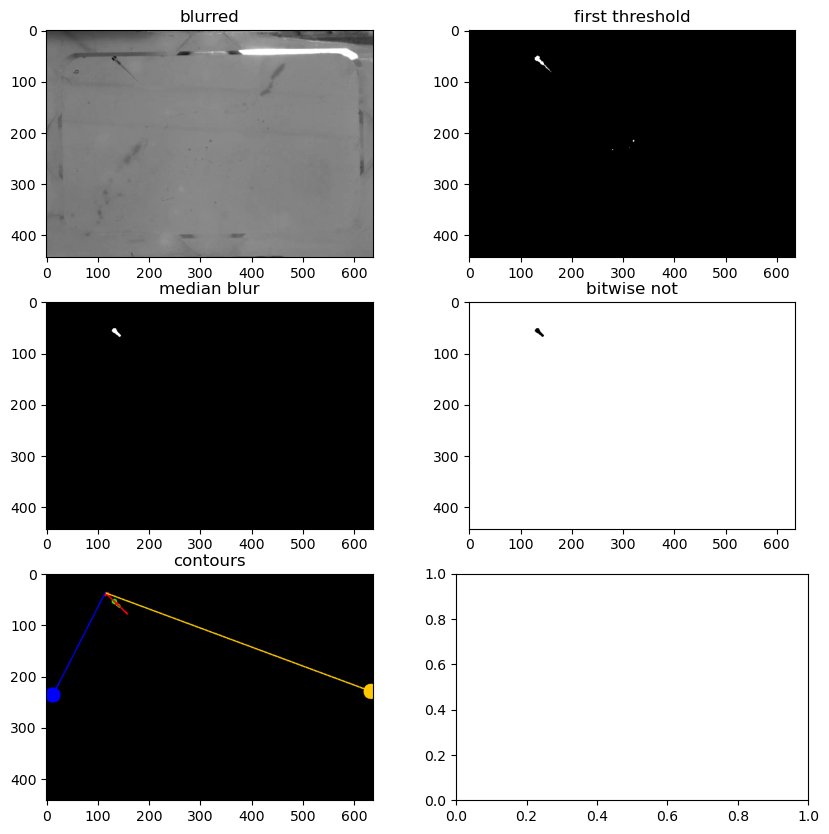

In [11]:
im = cv2.subtract(bkgrnd, cropped)
im = cv2.GaussianBlur(im, (3,3), 0)
# Threshold arguments: image/array, value for threshold (anything below 0, above kept),
# value to change to
r, i = cv2.threshold(im, 20, 255, 0)
# v.threshold(	src, thresh, maxval, type[, dst]	)
m = cv2.medianBlur(i, 7)
n = cv2.bitwise_not(m)
contours, hierarchy = cv2.findContours(i, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
filtered_contours_and_areas = [
    (contour, cv2.contourArea(contour))for contour in contours if cv2.contourArea(contour) > 20]
filtered_contours = [contour for contour, area in filtered_contours_and_areas]
contour = filtered_contours[0]
# Convert the list of contours into a NumPy array
filtered_contours_array = np.array(filtered_contours, dtype=object)
  # -1 means draw all contours, (0, 255, 0) is the color (green), and 3 is the thickness
# Convert the image from BGR to RGB (for proper display with matplotlib)
moments = cv2.moments(filtered_contours[0])
cX = int(moments["m10"] / moments["m00"])
cY = int(moments["m01"] / moments["m00"])
mu11 = moments['mu11']
mu20 = moments['mu20']
mu02 = moments['mu02']
angle = (0.5 * np.arctan2(2 * mu11, mu20 - mu02))
angle_degrees = np.degrees(angle)
img_rgb = cv2.cvtColor(m, cv2.COLOR_GRAY2BGR)
img_rgb = cv2.circle(img_rgb, (cX,cY), radius=3, color=(255, 0, 0), thickness=-1)
cv2.drawContours(img_rgb, filtered_contours, -1, (0, 255, 0), thickness=cv2.FILLED)
img_rgb = cv2.circle(img_rgb, (cX,cY), radius=3, color=(255, 0, 0), thickness=-1)
img_rgb = cv2.circle(img_rgb, points[0], radius=15, color=(255,200,0), thickness=-1)
img_rgb = cv2.circle(img_rgb, points[1], radius=15, color=(0,0,255), thickness=-1)
# Calculate the end point of the line
line_length = 30
x1 = int(cX + line_length * np.cos(angle))
y1 = int(cY + line_length * np.sin(angle))
x2 = int(cX - line_length * np.cos(angle))
y2 = int(cY - line_length * np.sin(angle))

dist_etoh = np.linalg.norm(np.array(points[0]) - np.array([cX, cY]))
dist_h20 = np.linalg.norm(np.array(points[1]) - np.array([cX, cY]))
# use line of orientation for vector
line_vector = np.array([x2, y2]) - np.array([x1, y1])
point_vector = np.array(points[0]) - np.array([x2, y2])
dot_product = np.dot(line_vector, point_vector)
line_vector_magnitude = np.linalg.norm(line_vector)
point_vector_magnitude = np.linalg.norm(point_vector)

# Calculate the angle in radians
angle_radians = np.arccos(dot_product / (line_vector_magnitude * point_vector_magnitude))

# Convert the angle to degrees
angle_degrees = np.degrees(angle_radians)
print(angle_degrees)
# use line of orientation for vector
line_vector2 = np.array([x2, y2]) - np.array([x1, y1])
point_vector2 = np.array(points[1]) - np.array([x2, y2])
dot_product2 = np.dot(line_vector2, point_vector2)
line_vector_magnitude2 = np.linalg.norm(line_vector2)
point_vector_magnitude2 = np.linalg.norm(point_vector2)

# Calculate the angle in radians
angle_radians2 = np.arccos(dot_product2 / (line_vector_magnitude2 * point_vector_magnitude2))

# Convert the angle to degrees
angle_degrees2 = np.degrees(angle_radians2)

cv2.arrowedLine(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)
cv2.line(img_rgb, (x2, y2), points[0], (255, 200, 0), thickness=2)
cv2.line(img_rgb, (x2, y2), points[1], (0, 0, 255), thickness=2)
fig2, axs = plt.subplots(3, 2, figsize=(10, 10))
axs[0,0].imshow(cropped, cmap='gray')
axs[0,0].set_title('blurred')
axs[0,1].imshow(i, cmap='gray')
axs[0,1].set_title('first threshold')
axs[1,0].imshow(m, cmap='gray')
axs[1,0].set_title('median blur')
axs[1,1].imshow(n, cmap='gray')
axs[1,1].set_title('bitwise not')
axs[2,0].imshow(img_rgb)
axs[2,0].set_title('contours')

In [15]:
import cv2
import os

def create_video_clip(input_video_path, output_video_path, start_time, end_time):
    # Verify the input file exists
    if not os.path.isfile(input_video_path):
        print(f"Error: The file {input_video_path} does not exist.")
        return

    # Open the video file
    cap = cv2.VideoCapture(input_video_path)

    # Check if video file opened successfully
    if not cap.isOpened():
        print(f"Error: Could not open video file {input_video_path}")
        return

    # Get frames per second (fps) and frame count
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate start and end frames
    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # For .mp4 file
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    current_frame = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if start_frame <= current_frame <= end_frame:
            out.write(frame)

        current_frame += 1
        if current_frame > end_frame:
            break

    # Release everything if job is finished
    cap.release()
    out.release()
    print(f"Video clip created successfully: {output_video_path}")

# Example usage
input_video = '/absolute/path/to/your/input_video.mp4'
output_video = 'output_video.mp4'
start_time = 10  # Start time in seconds
end_time = 20    # End time in seconds

create_video_clip(filename, output_video, start_time, end_time)


Video clip created successfully: output_video.mp4


In [ ]:
class Cropper:
    def __init__(self, video_path):
        self.video_path = video_path
        self.roi = None

    def select_roi(self):
        cap = cv2.VideoCapture(self.video_path)
        ret, frame = cap.read()
        if not ret:
            print("Failed to read video")
            cap.release()
            return
        
        # Select ROI
        self.roi = cv2.selectROI("Select ROI", frame, fromCenter=False, showCrosshair=True)
        cv2.destroyAllWindows()
        cap.release()

    def crop_and_save(self, output_path):
        if self.roi is None:
            print("ROI not set. Use select_roi() first.")
            return

        cap = cv2.VideoCapture(self.video_path)
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_path, fourcc, 20.0, (int(self.roi[2]), int(self.roi[3])))

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Crop the frame
            x, y, w, h = self.roi
            cropped_frame = frame[y:y+h, x:x+w]

        cap.release()
        print(f"Cropped video saved to {output_path}")

cropper = Cropper(video_path)
cropper.select_roi()  # Manually select the ROI from the first frame
cropper.crop_and_save(output_path)


In [ ]:
def log_file_system_info(logger, video_path):
    print(video_path)
    stat_info = os.stat(str(video_path))
    logger.info(f"File size: {stat_info.st_size} bytes")
    logger.info(f"Last modified: {time.ctime(stat_info.st_mtime)}")
    logger.info(f"Last accessed: {time.ctime(stat_info.st_atime)}")
# def data_producer(video, data_queue, stop_event, roi, background, points, previous_location, total_frames, progress_queue):
#     frame_count = 0
#     retry_count = 0 # Retry count for reading frames
#     max_retries = 10 # Max number of retries before giving up
#     start_time = time.time()
#     try:
#         while not stop_event.is_set() and video.isOpened() and frame_count < total_frames:
#             ret, frame = video.read()
            
#             if frame_count > total_frames * 0.80:  # Start logging after 70% completion
#                 print(f"Processing frame {frame_count}/{total_frames}")
#                 print(f"Return value from video.read(): {ret}")
            
#             if frame_count % 100 == 0:
#                 log_memory_usage()
            
#             if not ret:
#                 print(f"Failed to read frame at count {frame_count}")
#                 warnings.warn(f"Failed to read frame at count {frame_count}, retrying ({retry_count}/{max_retries})", VideoProcessingWarning)
#                 retry_count += 1
#                 if retry_count > max_retries:
#                     raise VideoReadError(f"Failed to read frame at count {frame_count} after {max_retries} retries.")
#                 video.set(cv2.CAP_PROP_POS_FRAMES, frame_count)
#                 time.sleep(0.1)  # Small delay before retrying
#                 continue
        
#             retry_count = 0  # Reset retry count on successful read
    
#             frame_count += 1
#             current_time = time.time()
#             elapsed_time = current_time - start_time
#             fps = frame_count / elapsed_time if elapsed_time > 0 else 0
    
#             frame = cv2.cvtColor(np.array(frame), cv2.COLOR_BGR2GRAY)
#             cropped = frame[roi[1]:roi[1] + roi[3], roi[0]:roi[0] + roi[2]]
    
#             if not isinstance(background, np.ndarray):
#                 raise ValueError("Background frame (background) is not a numpy array.")
#             if cropped.shape != background.shape:
#                 raise ValueError(f"Cropped frame shape {cropped.shape} does not match background frame shape {background.shape}.")
    
#             subtracted = cv2.subtract(background, cropped)
#             blurred = cv2.GaussianBlur(subtracted, (3, 3), 0)
#             _, thresholded = cv2.threshold(blurred, 20, 255, 0)
#             inverted = cv2.bitwise_not(thresholded)
#             median = cv2.medianBlur(thresholded, 7)
#             contours, _ = cv2.findContours(median, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#             filtered_contours_and_areas = [(contour, cv2.contourArea(contour)) for contour in contours if cv2.contourArea(contour) > 20]
#             if filtered_contours_and_areas:
#                 filtered_contours = [contour for contour, area in [max(filtered_contours_and_areas, key=lambda x: x[1])]]
#                 contour = filtered_contours[0]
#                 moments = cv2.moments(contour)
#                 cX = round(int(moments["m10"] / moments["m00"]), 2)
#                 cY = round(int(moments["m01"] / moments["m00"]), 2)
#                 previous_location[0], previous_location[1] = cX, cY
#             else:
#                 if previous_location[0] is not None and previous_location[1] is not None:
#                     cX = previous_location[0]
#                     cY = previous_location[1]
#                 else:
#                     cX = np.nan
#                     cY = np.nan
    
#             dist_etoh = np.linalg.norm(np.array(points[0]) - np.array([cX, cY]))
#             dist_h2o = np.linalg.norm(np.array(points[1]) - np.array([cX, cY]))
    
#             data_queue.put((cX, cY, dist_etoh, dist_h2o))
#             progress_queue.put(1)
#     except VideoReadError as e:
#         print(f"Video read error: {str(e)}")
#         print(f"Last successfully read frame: {frame_count}")
#         print(f"Video info: total_frames={total_frames}, isOpened={video.isOpened()}")
#     except Exception as e:
#         print(f"Unexpected error in producer: {str(e)}")
#         traceback.print_exc()
#     finally:
#         print(f"Producer exiting. Frames processed: {frame_count}")
#         stop_event.set()

# def data_producer(video, data_queue, stop_event, roi, background, points, previous_location=[None, None]):
#     frame_count = 0
#     total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
#     start_time = time.time()
#     with tqdm(total=total_frames, desc="Processing Frames", unit="frame") as pbar:
#         while not stop_event.is_set() and video.isOpened():
#             # Capture frame-by-frame
#             ret, frame = video.read()
#             if not ret:
#                 print(f"Failed to read frame at count {frame_count}")
#                 break

#             frame_count += 1
#             current_time = time.time()
#             elapsed_time = current_time - start_time
#             fps = frame_count / elapsed_time if elapsed_time > 0 else 0
#             pbar.set_description(f"Processing Frames (FPS: {fps:.2f})")
#             pbar.update(1)

#             frame = cv2.cvtColor(np.array(frame), cv2.COLOR_BGR2GRAY)
#             cropped = frame[roi[1]:roi[1] + roi[3], roi[0]:roi[0] + roi[2]]

#             # Ensure background is a numpy array
#             if not isinstance(background, np.ndarray):
#                 raise ValueError("Background frame (background) is not a numpy array.")
#             # Ensure shapes match
#             if cropped.shape != background.shape:
#                 raise ValueError(f"Cropped frame shape {cropped.shape} does not match background frame shape {background.shape}.")

#             subtracted = cv2.subtract(background, cropped)
#             blurred = cv2.GaussianBlur(subtracted, (3, 3), 0)
#             r, thresholded = cv2.threshold(blurred, 20, 255, 0)
#             inverted = cv2.bitwise_not(thresholded)
#             median = cv2.medianBlur(thresholded, 7)
#             contours, hierarchy = cv2.findContours(
#                 median, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
#             )
#             filtered_contours_and_areas = [
#                 (contour, cv2.contourArea(contour)) for contour in contours if cv2.contourArea(contour) > 20
#             ]
#             if filtered_contours_and_areas:
#                 filtered_contours = [contour for contour, area in [max(filtered_contours_and_areas, key=lambda x: x[1])]]
#                 contour = filtered_contours[0]
#                 moments = cv2.moments(contour)
#                 cX = round(int(moments["m10"] / moments["m00"]), 2)
#                 cY = round(int(moments["m01"] / moments["m00"]), 2)
#                 previous_location[0], previous_location[1] = cX, cY
#             else:
#                 if previous_location[0] is not None and previous_location[1] is not None:
#                     cX = previous_location[0]
#                     cY = previous_location[1]
#                 else:
#                     cX = np.nan
#                     cY = np.nan

#             dist_etoh = np.linalg.norm(np.array(points[0]) - np.array([cX, cY]))
#             dist_h2o = np.linalg.norm(np.array(points[1]) - np.array([cX, cY]))

#             data_queue.put((cX, cY, dist_etoh, dist_h2o))

# def data_consumer(data_queue, stop_event, file_path, roi, points):
#     with h5py.File(file_path, 'w') as h5f:  # Use 'w' mode to create a new file
#         # Create datasets with initial size and max shape
#         dset_center = h5f.create_dataset('center', (0, 2), maxshape=(None, 2), dtype='f')
#         dset_dist_etoh = h5f.create_dataset('dist_etoh', (0,), maxshape=(None,), dtype='f')
#         dset_dist_h2o = h5f.create_dataset('dist_h2o', (0,), maxshape=(None,), dtype='f')

#         # Optionally, add other attributes
#         h5f.attrs['roi'] = roi
#         h5f.attrs['points'] = np.array(points).flatten()

#         while not stop_event.is_set() or not data_queue.empty():
#             try:
#                 cX, cY, dist_etoh, dist_h2o = data_queue.get(timeout=1)

#                 # Resize datasets to accommodate new data
#                 dset_center.resize(dset_center.shape[0] + 1, axis=0)
#                 dset_dist_etoh.resize(dset_dist_etoh.shape[0] + 1, axis=0)
#                 dset_dist_h2o.resize(dset_dist_h2o.shape[0] + 1, axis=0)

#                 # Append new data
#                 dset_center[-1] = [cX, cY]
#                 dset_dist_etoh[-1] = dist_etoh
#                 dset_dist_h2o[-1] = dist_h2o

#                 data_queue.task_done()
#             except queue.Empty:
#                 continue

# def process_video(path, data_directory):
#     print("Processing:", path.stem)

#     video = cv2.VideoCapture(str(path))

#     # If it can't open the video, tell user there's an error
#     if not video.isOpened():
#         raise ValueError("Failed to open the video file.")
        
#     # Get video properties like filename, framerate, resolution, etc
#     vid_name = Path(path).stem
#     framerate = video.get(cv2.CAP_PROP_FPS)
#     points, background, roi = preprocess_video(video, data_directory)

#     h5_filepath = path.parent / "output.h5"

#     data_queue = queue.Queue(maxsize=100)
#     stop_event = threading.Event()

#     producer_thread = threading.Thread(target=data_producer, args=(video, data_queue, stop_event, roi, background, points))
#     consumer_thread = threading.Thread(target=data_consumer, args=(data_queue, stop_event, h5_filepath, roi, points))
    
#     producer_thread.start()
#     consumer_thread.start()
    
#     try:
#         # Wait for both threads to complete
#         producer_thread.join()
#         consumer_thread.join()
#     except KeyboardInterrupt:
#         print("Stopping...")
#     finally:
#         stop_event.set()
#         producer_thread.join()
#         consumer_thread.join()
#         video.release()
#         cv2.destroyAllWindows()
#         print("Data processing completed.")
#     # Release the video to make sure it's not corrupted
#     video.release()

# def main():
#     Tk().withdraw()
#     data_directory = Path(askdirectory())
#     video_paths = get_videos(data_directory)

#     processes = []
#     for path in video_paths:
#         print(f"Starting process for: {path}")
#         p = multiprocessing.Process(target=process_video, args=(path, data_directory))
#         p.start()
#         processes.append(p)

#     for p in processes:
#         p.join()
#         print(f"Process {p.pid} completed.")


####################

# def data_producer(video, data_queue, stop_event, roi, background, points, previous_location=[None, None]):
#     frame_count = 0
#     total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
#     start_time = time.time()
#     while not stop_event.is_set() and video.isOpened():
#         ret, frame = video.read()
#         if not ret:
#             print(f"Failed to read frame at count {frame_count}")
#             break

#         frame_count += 1
#         current_time = time.time()
#         elapsed_time = current_time - start_time
#         fps = frame_count / elapsed_time if elapsed_time > 0 else 0

#         frame = cv2.cvtColor(np.array(frame), cv2.COLOR_BGR2GRAY)
#         cropped = frame[roi[1]:roi[1] + roi[3], roi[0]:roi[0] + roi[2]]

#         if not isinstance(background, np.ndarray):
#             raise ValueError("Background frame (background) is not a numpy array.")
#         if cropped.shape != background.shape:
#             raise ValueError(f"Cropped frame shape {cropped.shape} does not match background frame shape {background.shape}.")

#         subtracted = cv2.subtract(background, cropped)
#         blurred = cv2.GaussianBlur(subtracted, (3, 3), 0)
#         _, thresholded = cv2.threshold(blurred, 20, 255, 0)
#         inverted = cv2.bitwise_not(thresholded)
#         median = cv2.medianBlur(thresholded, 7)
#         contours, _ = cv2.findContours(median, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#         filtered_contours_and_areas = [(contour, cv2.contourArea(contour)) for contour in contours if cv2.contourArea(contour) > 20]
#         if filtered_contours_and_areas:
#             filtered_contours = [contour for contour, area in [max(filtered_contours_and_areas, key=lambda x: x[1])]]
#             contour = filtered_contours[0]
#             moments = cv2.moments(contour)
#             cX = round(int(moments["m10"] / moments["m00"]), 2)
#             cY = round(int(moments["m01"] / moments["m00"]), 2)
#             previous_location[0], previous_location[1] = cX, cY
#         else:
#             if previous_location[0] is not None and previous_location[1] is not None:
#                 cX = previous_location[0]
#                 cY = previous_location[1]
#             else:
#                 cX = np.nan
#                 cY = np.nan

#         dist_etoh = np.linalg.norm(np.array(points[0]) - np.array([cX, cY]))
#         dist_h2o = np.linalg.norm(np.array(points[1]) - np.array([cX, cY]))

#         data_queue.put((cX, cY, dist_etoh, dist_h2o))

# def data_consumer(data_queue, stop_event, file_path, roi, points):
#     with h5py.File(file_path, 'w') as h5f:
#         dset_center = h5f.create_dataset('center', (0, 2), maxshape=(None, 2), dtype='f')
#         dset_dist_etoh = h5f.create_dataset('dist_etoh', (0,), maxshape=(None,), dtype='f')
#         dset_dist_h2o = h5f.create_dataset('dist_h2o', (0,), maxshape=(None,), dtype='f')

#         h5f.attrs['roi'] = roi
#         h5f.attrs['points'] = np.array(points).flatten()

#         while not stop_event.is_set() or not data_queue.empty():
#             try:
#                 cX, cY, dist_etoh, dist_h2o = data_queue.get(timeout=1)

#                 dset_center.resize(dset_center.shape[0] + 1, axis=0)
#                 dset_dist_etoh.resize(dset_dist_etoh.shape[0] + 1, axis=0)
#                 dset_dist_h2o.resize(dset_dist_h2o.shape[0] + 1, axis=0)

#                 dset_center[-1] = [cX, cY]
#                 dset_dist_etoh[-1] = dist_etoh
#                 dset_dist_h2o[-1] = dist_h2o

#                 data_queue.task_done()
#             except queue.Empty:
#                 continue

# def process_video(path, data_directory, progress_queue, position):
#     print(f"Processing: {path.stem}")

#     video = cv2.VideoCapture(str(path))
#     if not video.isOpened():
#         raise ValueError("Failed to open the video file.")
#     total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
#     vid_name = Path(path).stem
#     points, background, roi = preprocess_video(video, data_directory)

#     h5_filepath = path.parent / f"{vid_name}_output.h5"
#     data_queue = queue.Queue(maxsize=100)
#     stop_event = threading.Event()

#     producer_thread = threading.Thread(target=data_producer, args=(video, data_queue, stop_event, roi, background, points))
#     consumer_thread = threading.Thread(target=data_consumer, args=(data_queue, stop_event, h5_filepath, roi, points))

#     producer_thread.start()
#     consumer_thread.start()

#     try:
#         with tqdm(total=total_frames, desc=f'Process {current_process().name}', position=position, leave=True) as progress_bar:
#             while producer_thread.is_alive() or not data_queue.empty():
#                 if not progress_queue.empty():
#                     progress_bar.update(progress_queue.get())
#     except KeyboardInterrupt:
#         print("Stopping...")
#     finally:
#         stop_event.set()
#         producer_thread.join()
#         consumer_thread.join()
#         video.release()
#         cv2.destroyAllWindows()
#         print("Data processing completed.")

#     video.release()

# def process_worker(video_path, data_directory, position):
#     progress_queue = Queue()
#     process_video(video_path, data_directory, progress_queue, position)

# def main():
#     Tk().withdraw()
#     data_directory = Path(askdirectory())
#     video_paths = get_videos(data_directory)
#     processes = []
#     for i, video_path in enumerate(video_paths):
#         process = Process(target=process_worker, args=(video_path, data_directory, i))
#         process.start()
#         processes.append(process)

#     for process in processes:
#         process.join()

##############################

In [ ]:
def data_producer(video, data_queue, stop_event, roi, background, points, previous_location, total_frames, progress_queue, video_name):
    logger = get_process_logger(video_name, "producer")
    logger.info("Starting data producer")
    
    log_video_info(logger, video)
    
    start_logging = int(total_frames * 0.75)
    end_logging = int(total_frames * 0.85)
    
    logger.info(f"Will log detailed information for frames {start_logging} to {end_logging}")

    frame_count = 0
    max_retry = 10
    prev_frame = None
    try:
        while not stop_event.is_set() and video.isOpened() and frame_count < total_frames:
            start_time = time.time()
            ret, frame = video.read()
            read_time = time.time() - start_time
    
            if start_logging <= frame_count <= end_logging:
                log_frame_info(logger, video, frame_count)
                log_frame_read_time(logger, frame_count, read_time)
                analyze_frame_difference(logger, prev_frame, frame)
                log_keyframe_info(logger, video, frame_count)
    
            if not ret or not check_frame_integrity(frame):
                for retry in range(max_retry):
                    logger.info(f"Retrying frame {frame_count}, attempt {retry + 1}/{max_retry}")
                    video.set(cv2.CAP_PROP_POS_FRAMES, frame_count)
                    ret, frame = video.read()
                    if ret and check_frame_integrity(frame):
                        break
                    log_retry_info(logger, retry, 10, frame_count, ret, frame)
                    time.sleep(0.1)
    
                if not ret or not check_frame_integrity(frame):
                    logger.error(f"Failed to read frame {frame_count} after 10 retries")
                    break
                
                frame = cv2.cvtColor(np.array(frame), cv2.COLOR_BGR2GRAY)
                cropped = frame[roi[1]:roi[1] + roi[3], roi[0]:roi[0] + roi[2]]
        
                if not isinstance(background, np.ndarray):
                    raise ValueError("Background frame (background) is not a numpy array.")
                if cropped.shape != background.shape:
                    raise ValueError(f"Cropped frame shape {cropped.shape} does not match background frame shape {background.shape}.")
        
                subtracted = cv2.subtract(background, cropped)
                blurred = cv2.GaussianBlur(subtracted, (3, 3), 0)
                _, thresholded = cv2.threshold(blurred, 20, 255, 0)
                inverted = cv2.bitwise_not(thresholded)
                median = cv2.medianBlur(thresholded, 7)
                contours, _ = cv2.findContours(median, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                filtered_contours_and_areas = [(contour, cv2.contourArea(contour)) for contour in contours if cv2.contourArea(contour) > 20]
                if filtered_contours_and_areas:
                    filtered_contours = [contour for contour, area in [max(filtered_contours_and_areas, key=lambda x: x[1])]]
                    contour = filtered_contours[0]
                    moments = cv2.moments(contour)
                    cX = round(int(moments["m10"] / moments["m00"]), 2)
                    cY = round(int(moments["m01"] / moments["m00"]), 2)
                    previous_location[0], previous_location[1] = cX, cY
                else:
                    if previous_location[0] is not None and previous_location[1] is not None:
                        cX = previous_location[0]
                        cY = previous_location[1]
                    else:
                        cX = np.nan
                        cY = np.nan
        
                dist_etoh = np.linalg.norm(np.array(points[0]) - np.array([cX, cY]))
                dist_h2o = np.linalg.norm(np.array(points[1]) - np.array([cX, cY]))
        
                data_queue.put((cX, cY, dist_etoh, dist_h2o))
                progress_queue.put(1)
    
            if start_logging <= frame_count <= end_logging:
                prev_frame = frame.copy()
            else:
                prev_frame = None

    except VideoReadError as e:
        logger.error(f"Video read error: {str(e)}")
        logger.error(f"Last successfully read frame: {frame_count}")
        logger.error(f"Video info: total_frames={total_frames}, isOpened={video.isOpened()}")
    except Exception as e:
        logger.error(f"Unexpected error in producer: {str(e)}")
        logger.error(traceback.format_exc())
    finally:
        stop_event.set()


def data_consumer(data_queue, stop_event, file_path, roi, points):
    with h5py.File(file_path, 'w') as h5f:
        dset_center = h5f.create_dataset('center', (0, 2), maxshape=(None, 2), dtype='f')
        dset_dist_etoh = h5f.create_dataset('dist_etoh', (0,), maxshape=(None,), dtype='f')
        dset_dist_h2o = h5f.create_dataset('dist_h2o', (0,), maxshape=(None,), dtype='f')

        h5f.attrs['roi'] = roi
        h5f.attrs['points'] = np.array(points).flatten()

        while not stop_event.is_set() or not data_queue.empty():
            try:
                cX, cY, dist_etoh, dist_h2o = data_queue.get(timeout=1)

                dset_center.resize(dset_center.shape[0] + 1, axis=0)
                dset_dist_etoh.resize(dset_dist_etoh.shape[0] + 1, axis=0)
                dset_dist_h2o.resize(dset_dist_h2o.shape[0] + 1, axis=0)

                dset_center[-1] = [cX, cY]
                dset_dist_etoh[-1] = dist_etoh
                dset_dist_h2o[-1] = dist_h2o

                data_queue.task_done()
            except queue.Empty:
                continue

In [ ]:
def check_frame_integrity(frame):
    if frame is None or frame.size == 0:
        return False
    if np.isnan(frame).any() or np.isinf(frame).any():
        return False
    return True
